## Quick and dirty trust simulation

In [79]:
import mate
import avstack

from avstack.geometry import GlobalOrigin3D, Position

import numpy as np
import matplotlib.pyplot as plt

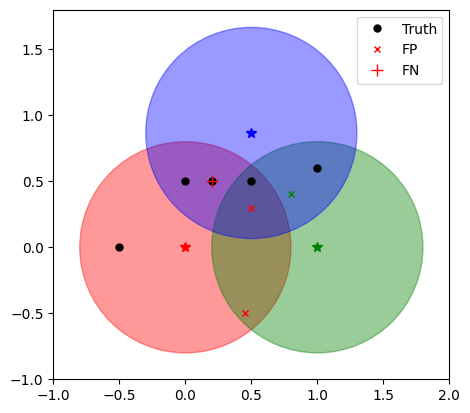

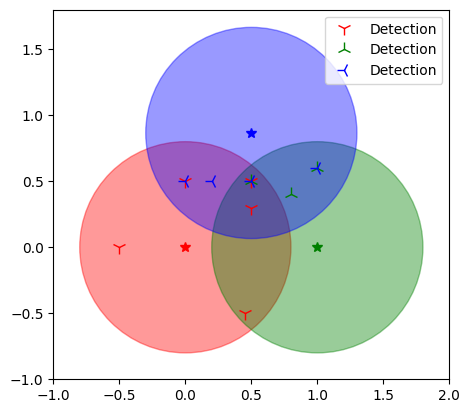

In [81]:
agents = [
    np.array([0, 0]),
    np.array([1, 0]),
    np.array([1/2, np.sqrt(3/4)])
]
radius = 0.8

objects = [
    np.array([0, 0.5]),   # in agents 0, 1
    np.array([0.2, 0.5]), # in agents 0, 1
    np.array([-0.5, 0]),  # in agent  1
    np.array([0.5, 0.5]), # in agents 0, 1, 2
    np.array([1, 0.6]),   # in agents 1, 2
]

false_positives = [
    (0, np.array([0.5, 0.3])),  # (agent 0, location)
    (0, np.array([0.45, -0.5])),
    (1, np.array([0.8, 0.4])),
]

false_negatives = [
    (0, 1),  # (agent 0, object 1)
]

detections = {}
for i, agent in enumerate(agents):
    dets = []
    for j, obj in enumerate(objects):
        if (i,j) in false_negatives:
            continue
        else:
            if np.linalg.norm(agent - obj) <= radius:
                dets.append(Position(x=obj, reference=GlobalOrigin3D))
    for j, fp in enumerate(false_positives):
        if fp[0] == i:
            dets.append(Position(x=fp[1], reference=GlobalOrigin3D))
    detections[i] = dets

# -- plot full picture
fig, ax = plt.subplots()
agent_colors = "rgb"
# plot agents
for agent, color in zip(agents, agent_colors):
    ax.plot(*agent, '*', markersize=7, color=color)
    circle = plt.Circle(agent, radius, color=color, alpha=0.4)
    ax.add_patch(circle)

# plot objects
for i, object in enumerate(objects):
    ax.plot(*object, 'o', markersize=5, color="black", label="Truth" if i==0 else "")

# plot false positives
for i, fp in enumerate(false_positives):
    ax.plot(*fp[1], 'x', markersize=5, color=agent_colors[fp[0]], label="FP" if i == 0 else "")

# plot false negatives
for i, fn in enumerate(false_negatives):
    ax.plot(*objects[fn[1]], '+', markersize=8, color=agent_colors[fn[0]], label="FN" if i == 0 else "")

# set limits
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 1.8])
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.show()


# -- plot detections only
fig, ax = plt.subplots()
agent_colors = "rgb"
# plot agents
for agent, color in zip(agents, agent_colors):
    ax.plot(*agent, '*', markersize=7, color=color)
    circle = plt.Circle(agent, radius, color=color, alpha=0.4)
    ax.add_patch(circle)

# plot detections
det_markers = "123"
for i_agent, dets in detections.items():
    for j, det in enumerate(dets):
        ax.plot(*det.x, det_markers[i_agent], markersize=10, alpha=1, color=agent_colors[i_agent],
                label="Detection" if j==0 else "")

# set limits
ax.set_xlim([-1, 2])
ax.set_ylim([-1, 1.8])
ax.set_aspect('equal', adjustable='box')
plt.legend()
plt.show()



In [102]:
clust.get_tracks_by_agent_ID(2)

[<class 'avstack.geometry.datastructs.Position'> - [0.2 0.5], GlobalOrigin]

In [103]:
clust.distance(clust.get_tracks_by_agent_ID(2)[0])

0.0

In [99]:
class PSM:
    def __init__(self, result, dist=None, p_exist=None):
        if result:
            assert dist is not None
        self.result = result
        self.dist = dist
        self.p_exist = p_exist


# let's say we already have some tracks on objects
idx_tracks = [0,1,2,4]
tracks = [obj for i, obj in enumerate(objects) if i in idx_tracks]

# cluster the detections
clusterer = avstack.modules.clustering.SampledAssignmentClusterer(assign_radius=0.05)
clusts = clusterer(detections, frame=0, timestamp=0)

# assign clusters to existing tracks
p_exist = 0.94


# check fov expectations for each cluster
psms_all = []
for clust in clusts:
    psms = []
    for i_agent, agent in enumerate(agents):
        if np.linalg.norm(agent - clust.centroid().x) <= radius:
            saw = i_agent in clust.agent_IDs  # did we see it?
            if saw:  # positive result
                dets = clust.get_tracks_by_agent_ID(i_agent)
                if len(dets) > 1:
                    raise RuntimeError
                dist = clust.distance(dets[0])
                psms.append(PSM(saw, dist=dist, p_exist=None))
            else:  # negative result
                psms.append(PSM(False))
        else:
            pass  # not expected to see
    psms_all.append(psms)

In [100]:
psms_all

[[True, True],
 [True],
 [True, True, True],
 [True, False, False],
 [True, False],
 [True, True],
 [True, False],
 [False, True]]